# Sub Basin Delineation

We want the catchment unique to each reach (unnested). 
Once we have the catchments we can work on extracting the valley bottom.

Both WhiteBoxTools (using subbasins) and GrassGIS (using r.watershed) can do this on a river network.

Using NHD stream flowlines presents two challenges:
1) How to handle when the flowline doesn't line up with the terrain
2) How to handle creating pour points unique to each segment. Where two segments meet, they share a coordinate.

For option 1) could try using the snap pour points tool on every single coordinate in the line segments. Then rasterize the line segments. Then continue with the workflow.

For 2) I think the easiest is to delineate the catchments at the segment level, and only then do further splitting by assigning pour points at specified locations on the segment to delineate a reach (e.g every 1000m).

Thus the workflow:
- Create a stream network raster (either by thresholding flow accumulation, or from NHD vectors)
- Run subbasins tool with input stream raster and d8 pointer
- Further split the subbasins using pour points

Alternatively, can start with the NHDPlus HUC12 Catchment boundaries. 

In [91]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray 
import os
import shutil
import tempfile
import whitebox
import shapely
import rasterio
from rasterio import features

In [185]:
# load toy data
dem = rioxarray.open_rasterio('../toy_data/dem_3m.tif')

## WhiteBoxTools

Workflow option 1:
 - Flow Accumulation (fill depressions, flow direction, flow accumulation)
 - Extract Streams (threshold flow accumulation)
 - SubBasins (input streams and flow direction)

In order to have reaches and not just stream network segments need option 2:
- Flow Accumulation
- Extract Streams
- Split Segments
- Get pour points (end of segment)
- Snap to flow accumulation (if using NHD)
- Watershed tool
- UnnestBasins (maybe not necessary)

In [78]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir(os.path.expanduser("~/opt/WBT/"))

working_directory = os.path.abspath("../data/whitebox_outputs/")
if os.path.exists(working_directory):
    shutil.rmtree(working_directory)
os.mkdir(working_directory)
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

### Extract SubBasins

In [79]:
# get flow direction and flow accumulation
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmpztwelbik.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 876
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.23s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif'

In [80]:
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)
d8_pntr_file

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.29s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif'

In [81]:
params = {
    "i": d8_pntr_file,
    "output": os.path.join(working_directory, "d8_flow_acc.tif"),
    "out_type": "cells",
    "log": False,
    "clip": False,
    "pntr": True,
    "esri_pntr": False,
    "callback": my_callback
}
flow_acc = wb_wrapper(wbt.d8_flow_accumulation, params, return_file=False)

./whitebox_tools --run="D8FlowAccumulation" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --input='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_flow_acc.tif' --out_type=cells --pntr -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.88s


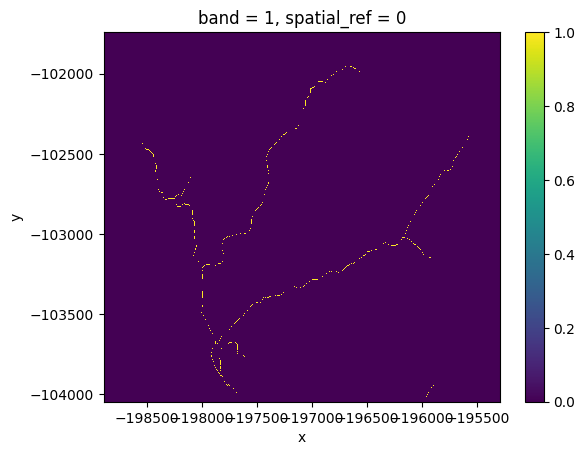

In [82]:
# decide on a threshold for flow accumulation
threshold = 30000
(flow_acc > threshold).plot()

In [83]:
params = {
    "flow_accum": flow_acc,
    "output": os.path.join(working_directory, "streams.tif"),
    "threshold": threshold,
    "zero_background": False,
    "callback": my_callback
}
streams_file = wb_wrapper(wbt.extract_streams, params, return_file=True)

./whitebox_tools --run="ExtractStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --flow_accum='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmp5_mysjnx.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --threshold='30000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.12s


In [84]:
params = {
    'd8_pntr': d8_pntr_file, 
    'streams': streams_file, 
    'output': os.path.join(working_directory, "subbasins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)

./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/subbasins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.89s


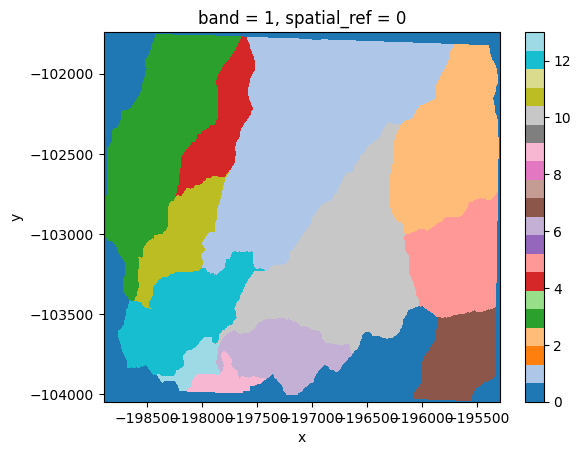

In [85]:
basins.data[basins.data == -32768] = 0
basins.plot(cmap='tab20')

## Vectorize Streams and Basin Boundaries

Want to create polygon boundaries for each subbasin
- either use geocube https://github.com/corteva/geocube/blob/master/docs/examples/vectorize.ipynb
- or https://rasterio.readthedocs.io/en/latest/topics/features.html
    
Given one subbasin polygon, clip the dem and the flowlines vectors
split the flowline (should only be one in the polygon) into equal length segments to get the pour points
run watershed


In [86]:
params = {
    'streams': streams_file, 
    'd8_pntr': d8_pntr_file, 
    'output': os.path.join(working_directory, "streams.shp"), 
    'esri_pntr': False, 
    'callback': my_callback
}
streams_shp_file = wb_wrapper(wbt.raster_streams_to_vector, params, return_file=True)

./whitebox_tools --run="RasterStreamsToVector" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --streams='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.shp' -v --compress_rasters=False

************************************
* Welcome to RasterStreamsToVector *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Reading pointer data...
Reading streams data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.8s


In [164]:
basins.rio.to_raster('../data/whitebox_outputs/subbasins.tif', driver="GTiff")
with rasterio.open(os.path.join(working_directory, 'subbasins.tif')) as src:
    b = src.read(1)

mask = b != -32768
shapes = features.shapes(b, mask=mask, transform=src.transform)

records = []
for shape,id in shapes:
    coords = shape['coordinates'][0]
    poly = shapely.Polygon(coords)
    records.append({'id': id, 'geometry': poly})
basin_polygons = gpd.GeoDataFrame.from_records(records)
# drop polygons with areas less than a few cell (in this case 100 square)
basin_polygons = basin_polygons[basin_polygons.area > 100]
basin_polygons

,id,geometry
4,4.0,"POLYGON ((-197640.980 -101767.900, -197625.994..."
5,2.0,"POLYGON ((-195707.747 -101812.859, -195704.749..."
10,1.0,"POLYGON ((-197596.022 -101770.897, -197497.112..."
11,3.0,"POLYGON ((-198420.269 -101749.916, -198393.293..."
12,11.0,"POLYGON ((-197760.871 -102610.131, -197757.874..."
13,5.0,"POLYGON ((-195315.105 -102736.016, -195312.108..."
14,10.0,"POLYGON ((-196310.196 -102304.410, -196289.215..."
17,12.0,"POLYGON ((-197596.022 -103104.679, -197587.030..."
19,13.0,"POLYGON ((-197979.671 -103644.186, -197910.734..."
20,6.0,"POLYGON ((-197317.276 -103521.298, -197275.315..."


<Axes: >

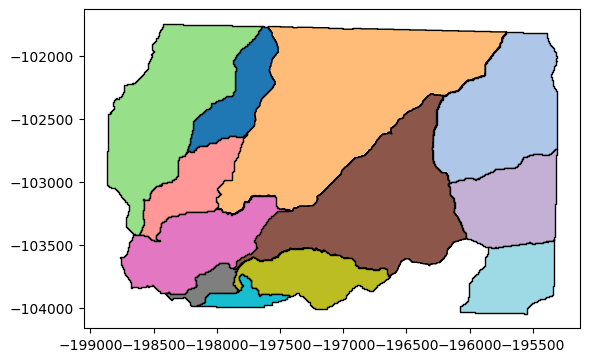

In [166]:
basin_polygons[basin_polygons['id'] > 0].plot(cmap='tab20', edgecolor='black')

<Axes: >

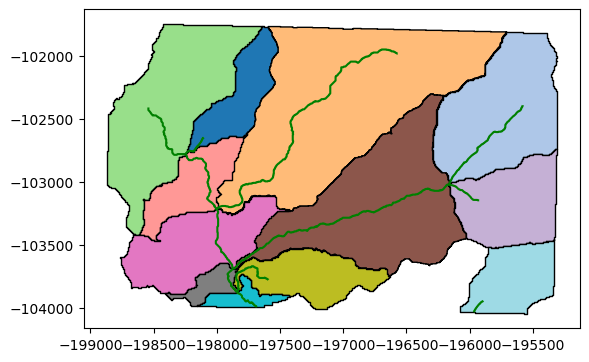

In [167]:
# want dataframe of basin_polygon, flowline
fig, ax = plt.subplots()
streams = gpd.read_file(streams_shp_file)
streams.plot(ax = ax, color='green')
basin_polygons[basin_polygons['id'] > 0].plot(cmap='tab20', edgecolor='black', ax=ax)

## Reach Delineation

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureW

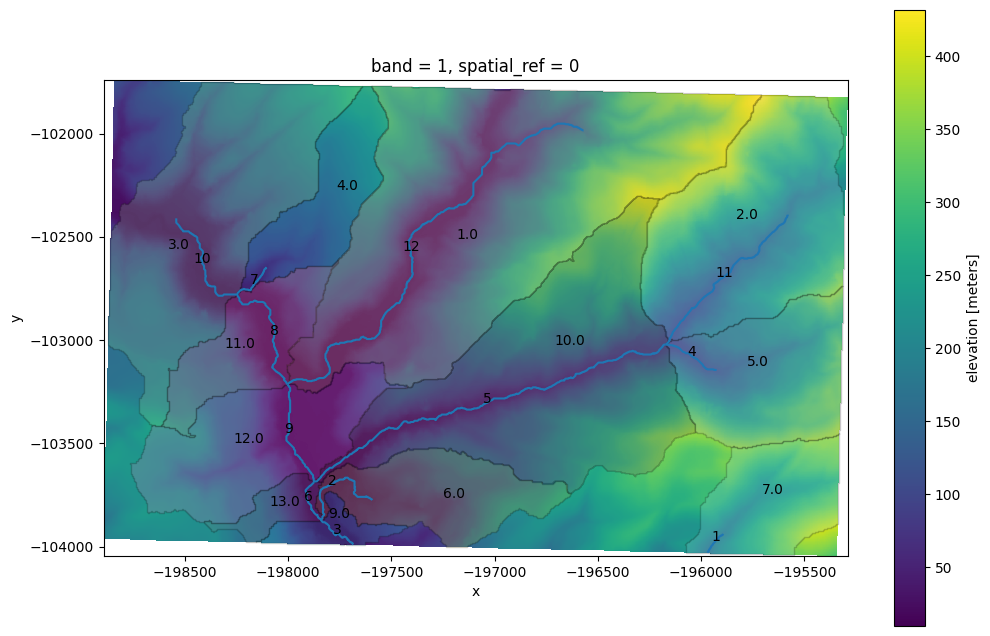

In [168]:
import xrspatial

basin_polygons = basin_polygons.loc[basin_polygons['id'] > 0]

fig, ax = plt.subplots(1,1, figsize=(12,8))
dem.plot(ax=ax)
basin_polygons.plot(cmap='tab20', edgecolor='black', ax=ax, alpha=0.2)
streams.plot(ax=ax)

basin_polygons['coords'] = basin_polygons['geometry'].apply(lambda x: x.representative_point().coords[:])
basin_polygons['coords'] = [coords[0] for coords in basin_polygons['coords']]
for idx, row in basin_polygons.iterrows():
    plt.annotate(text=row['id'], xy=row['coords'],
                 horizontalalignment='center')

streams['coords'] = streams['geometry'].apply(lambda x: x.representative_point().coords[:])
streams['coords'] = [coords[0] for coords in streams['coords']]
for idx, row in streams.iterrows():
    plt.annotate(text=row['FID'], xy=row['coords'],
                 horizontalalignment='center')

In [169]:
# for each coord see what stream is in it
results = []
for ind,brow in basin_polygons.iterrows():
    res = {}
    geom = brow['geometry']
    id = brow['id']
    res['id'] = id
    for ind,srow in streams.iterrows():
        c = srow['coords']
        FID = srow['FID']
        if geom.contains(shapely.Point(c)):
            res['FID'] = FID
            break
    results.append(res)
manifest = gpd.GeoDataFrame.from_records(results)
manifest

,id,FID
0,4.0,7
1,2.0,11
2,1.0,12
3,3.0,10
4,11.0,8
5,5.0,4
6,10.0,5
7,12.0,9
8,13.0,6
9,6.0,2


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

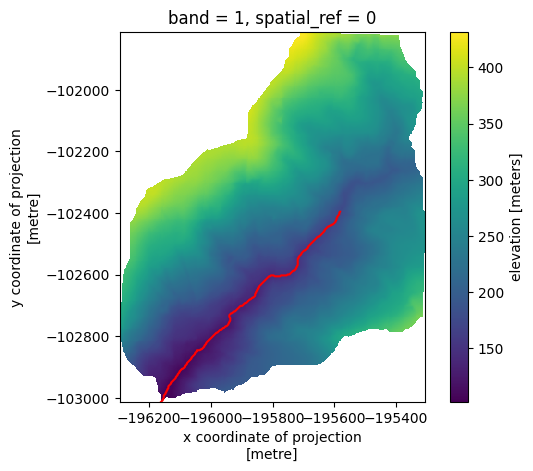

In [191]:
basin_id = 2
stream_id = manifest.loc[manifest['id'] == basin_id]['FID']
basin_dem = dem.rio.clip(basin_polygons.loc[basin_polygons['id'] == basin_id]['geometry'])
stream = streams.loc[streams['FID'] == 11]

fig, ax = plt.subplots()
basin_dem.plot(ax=ax)
stream.plot(ax=ax, color='red')

In [201]:
def segment(line, length=500, method="remainder"):
    # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
    # https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
    
    if method not in ['remainder', 'equal']:
        raise ValueError(f"method must be 'remainder' or 'equal' when {method} was provided")
    
    if method == "remainder":
        distances = np.arange(0, line.length, length)
    elif method == "equal":
        nparts = line.length // length
        if nparts == 0:
            distances = np.arange(0, line.length, line.length)
        else:        
            distances = np.arange(0, line.length, line.length/nparts)
        
    points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
    points = unary_union(points)
    return points

# get pour points along the stream
# snap pour points
# run watershed algorithm
# re polygonize
seg = stream['geometry']
points = segment(seg, length=1000)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().